# This notebook contains code for creating and evaluating the baseline model and subsequent models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
import math
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, fbeta_score, make_scorer, roc_auc_score, roc_curve, confusion_matrix

import imblearn.over_sampling

# Read in dataset for modeling

In [2]:
df_X = pd.read_csv('nypd_force_df.csv')

# Model Preparation

First, since I'm using logistic regression and I have numeric variables on different scales, I need to standardize them so they're on the same scale.

In [3]:
# scale numeric features
cols_to_scale = ['num_members','num_subjects','subject_age']
scaler = StandardScaler()
df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])

Next, I split my dataset twice: first, into training and test sets on randomly selected groups of non-NYPD subjects, so there isn't any overlap in the non-NYPD subjects in either set.

Then, I split the training set again into training and validation sets.

In [4]:
# split the data into train/validate/test sets on randomly selected groups of non-NYPD subjects

# all data -> train / test
np.random.seed(42)
total_subjects = df_X['subject_id'].unique() 
test_subjects = np.random.choice(total_subjects, size=int(total_subjects.shape[0] * .20))

df_X_tr_val, df_X_te = df_X[~df_X['subject_id'].isin(test_subjects)], df_X[df_X['subject_id'].isin(test_subjects)]


y_tr_val, y_te = df_X_tr_val['subject_injured'], df_X_te['subject_injured']
X_tr_val, X_te = df_X_tr_val.drop(['subject_id','tri_incident_number','subject_injured'],axis=1), \
             df_X_te.drop(['subject_id','tri_incident_number','subject_injured'],axis=1)


# train -> train / validation
X_tr, X_val, y_tr, y_val = train_test_split(X_tr_val, y_tr_val, test_size=.25, random_state=42)

Because my dataset is very imbalanced (approximately 98% are in the negative class and 2% are in the positive class), I'm choosing to deal with this first by oversampling.

In [5]:
# oversampling to deal with class imbalance for train data

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 

X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)

In [6]:
# oversampling to deal with class imbalance for validation data

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_val == 1)
n_neg = np.sum(y_val == 0)
ratio = {1 : n_pos * 4, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 

X_val_rs, y_val_rs = ROS.fit_resample(X_val, y_val)

Now that I have my datasets ready, I can create a helper function that will allow me to fit a model and cross-validate it using F2 and recall scores as my evaluation metrics.

In [7]:
def lr_model_cross_validate(X,y):
    
    scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
    
    lr = LogisticRegression(solver='lbfgs',max_iter=10000)
    
    lr.fit(X,y)
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    
    cv_results_lr = cross_validate(lr, X, y, cv=kf, scoring=scoring_metrics)

    # Report results
    
    print(f"recalls: {(cv_results_lr['test_rec'])}")
    print("")
    print(f"mean recall: {(np.mean(cv_results_lr['test_rec'])):.3f}")
    print("")
    print(f"f2 scores: {(cv_results_lr['test_f2_score'])}")
    print("")
    print(f"mean f2 score: {(np.mean(cv_results_lr['test_f2_score'])):.3f}")

# Baselining Model

I'm ready to create my baseline model! I'm going to make two versions: one without over-sampling and one with over-sampling, to notice the difference.

The version below does not include over-sampling.

In [8]:
lr_model_cross_validate(X_tr,y_tr)

recalls: [0.03333333 0.07407407 0.08333333 0.09677419 0.        ]

mean recall: 0.058

f2 scores: [0.04132231 0.09009009 0.10067114 0.1171875  0.        ]

mean f2 score: 0.070


The version below **does** include over-sampling.

In [9]:
lr_model_cross_validate(X_tr_rs,y_tr_rs)

recalls: [0.11666667 0.10655738 0.14285714 0.09459459 0.10434783]

mean recall: 0.113

f2 scores: [0.14084507 0.1284585  0.17068273 0.11400651 0.12605042]

mean f2 score: 0.136


By comparing the mean F2 and recall scores between each version, it's clear that the one with over-sampling performs someone better, as both scores are higher for each.

Next, I'll create confusion matrices to further evaluate the performance of the baseline model with over-sampling. I'll use separate training and validation data to do this.

In [10]:
# instantiate the model and fit it (I have to do this again, since when I did it above, it was within a function)

lr_base = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_base.fit(X_tr_rs, y_tr_rs)

LogisticRegression(max_iter=10000)

Confusion matrix of base model using training data

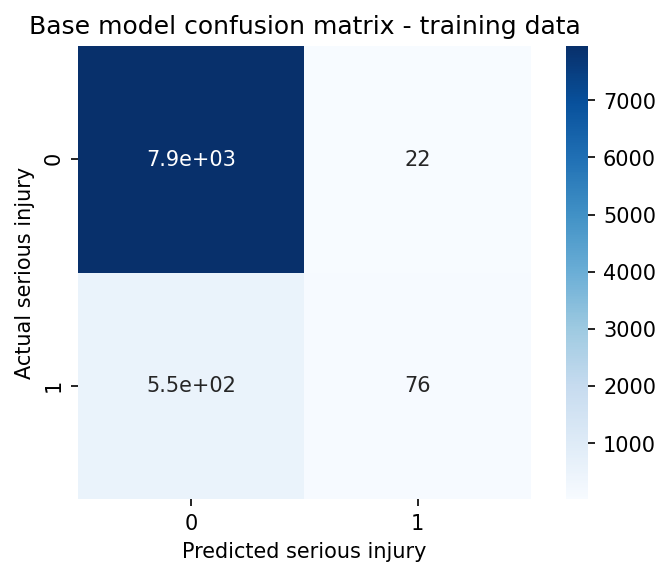

In [11]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_tr_rs, lr_base.predict(X_tr_rs))
plt.figure(dpi=150)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')
plt.title('Base model confusion matrix - training data');

#plt.savefig("confusion_matrix_base_train")

Confusion matrix of base model using validation data

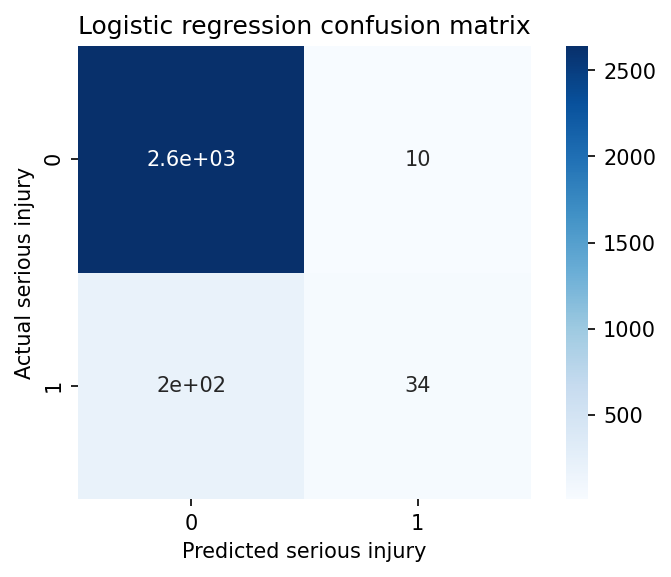

In [12]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_val_rs, lr_base.predict(X_val_rs))
plt.figure(dpi=150)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')
plt.title('Logistic regression confusion matrix');

By comparing the confusion matrices using first the training data and then the validation data, we can see that recall score for the training dataset is 76/(550+76) = ~ 12%. Meanwhile, with the validation data, the recall score is 34/(200+34) = ~ 15%, so it's slightly higher but still low. Precision for both is much better (76/(76+22)=78% and 34/(34+10)=77%).

Next, I'll plot the ROC curve for the baseline model with over-sampling. I'll use validation data for this.

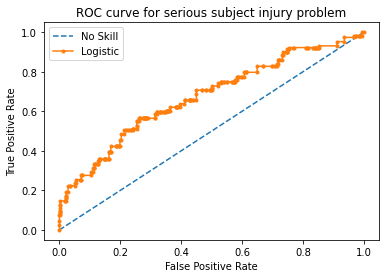

ROC AUC score =  0.6747681421454493


In [16]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val_rs, lr_base.predict_proba(X_val_rs)[:,1]) # lr.predict_proba(X_te)[:,1] means use probabilities for the positive outcome only

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()

# show the plot
plt.show()
print("ROC AUC score = ", roc_auc_score(y_val_rs, lr_base.predict_proba(X_val_rs)[:,1]))

# Second model

Since the performance of my baseline model with over-sampling can clearly be improved upon in terms of its recall and F2 scores, I'm going to work on further addressing the class imbalance problem issue by experimenting with adjusting class weights.

To being, I'll create another helper function that will allow me to run three versions of logistic regression models to test how adjusting the class weights will impact their performance levels. There is also cross-validation built into the function.

In [17]:
def lr_models_cross_validate(X,y):
    
    scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
    
    lr = LogisticRegression(solver='lbfgs',max_iter=10000)
    lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear')
    lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1}, solver='liblinear')
    
    lr.fit(X,y)
    lr_balanced.fit(X,y)
    lr_4x.fit(X,y)
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    
    cv_results_lr = cross_validate(lr, X, y, cv=kf, scoring=scoring_metrics)
    cv_results_lr_balanced = cross_validate(lr_balanced, X, y, cv=kf, scoring=scoring_metrics)
    cv_results_lr_4x = cross_validate(lr_4x, X, y, cv=kf, scoring=scoring_metrics)
    
    # Report results
    
    print(f"Normal Logistic Regression recall scores: {(cv_results_lr['test_rec'])}")
    print("")
    print(f"Normal Logistic Regression mean recall score: {(np.mean(cv_results_lr['test_rec'])):.3f}")
    print("")
    print(f"Normal Logistic Regression f2 score: {(cv_results_lr['test_f2_score'])}")
    print("")
    print(f"Normal Logistic Regression mean f2 score: {(np.mean(cv_results_lr['test_f2_score'])):.3f}")
    print("")
    print("")
    print(f"Balanced Logistic Regression recall scores: {(cv_results_lr_balanced['test_rec'])}")
    print("")
    print(f"Balanced Logistic Regression mean recall score: {(np.mean(cv_results_lr_balanced['test_rec'])):.3f}")
    print("")
    print(f"Balanced Logistic Regression f2 score: {(cv_results_lr_balanced['test_f2_score'])}")
    print("")
    print(f"Balanced Logistic Regression mean f2 score: {(np.mean(cv_results_lr_balanced['test_f2_score'])):.3f}")
    print("")
    print("")
    print(f"4:1 class weights Logistic Regression recall scores: {(cv_results_lr_4x['test_rec'])}")
    print("")
    print(f"4:1 class weights Logistic Regression mean recall score: {(np.mean(cv_results_lr_4x['test_rec'])):.3f}")
    print("")
    print(f"4:1 class weights Logistic Regression f2 score: {(cv_results_lr_4x['test_f2_score'])}")
    print("")
    print(f"4:1 class weights Logistic Regression mean f2 score: {(np.mean(cv_results_lr_4x['test_f2_score'])):.3f}")

In [18]:
lr_models_cross_validate(X_tr_rs,y_tr_rs)

Normal Logistic Regression recall scores: [0.11666667 0.10655738 0.14285714 0.09459459 0.10434783]

Normal Logistic Regression mean recall score: 0.113

Normal Logistic Regression f2 score: [0.14084507 0.1284585  0.17068273 0.11400651 0.12605042]

Normal Logistic Regression mean f2 score: 0.136


Balanced Logistic Regression recall scores: [0.70833333 0.71311475 0.6302521  0.68918919 0.66086957]

Balanced Logistic Regression mean recall score: 0.680

Balanced Logistic Regression f2 score: [0.41142304 0.38701068 0.33814247 0.43293718 0.37475345]

Balanced Logistic Regression mean f2 score: 0.389


4:1 class weights Logistic Regression recall scores: [0.24166667 0.2295082  0.23529412 0.23648649 0.19130435]

4:1 class weights Logistic Regression mean recall score: 0.227

4:1 class weights Logistic Regression f2 score: [0.26802218 0.25454545 0.26119403 0.26799387 0.21611002]

4:1 class weights Logistic Regression mean f2 score: 0.254


The above scores for each model with different class weights indicate that the one with balanced classes performs the best of the three. By comparing the scores of the normal logistic regression (which is the same as the baseline model), it's clear that the model with the balanced classes improves recall and F2 scores from cross-validation on train/validation data.

Next, I'll create confusion matrices to further evaluate the performance of the second model. I'll use separate training and validation data to do this.

In [19]:
# instantiate the model and fit it (I have to do this again, since when I did it above, it was within a function)

lr_2 = LogisticRegression(class_weight='balanced',solver='lbfgs',max_iter=10000)
lr_2.fit(X_tr_rs, y_tr_rs)

LogisticRegression(class_weight='balanced', max_iter=10000)

Confusion matrix of second model using training data

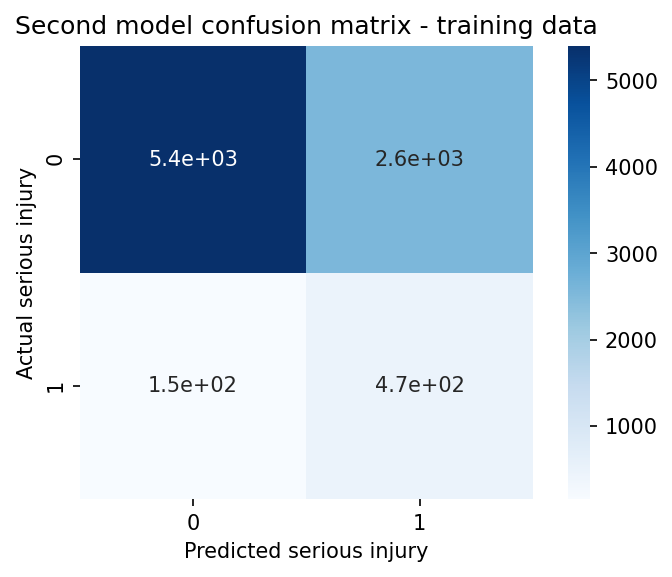

In [20]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_tr_rs, lr_2.predict(X_tr_rs))
plt.figure(dpi=150)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')
plt.title('Second model confusion matrix - training data');

#plt.savefig("confusion_matrix_base_train")

Confusion matrix of second model using validation data

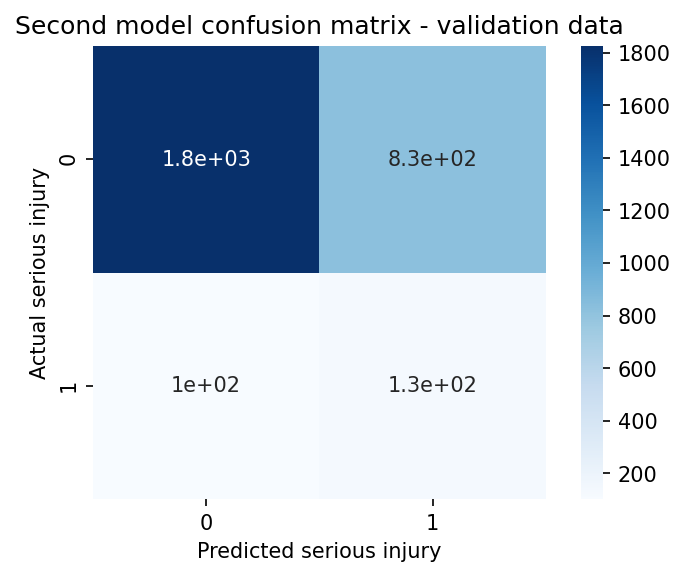

In [21]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_val_rs, lr_2.predict(X_val_rs))
plt.figure(dpi=150)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')
plt.title('Second model confusion matrix - validation data');

#plt.savefig("confusion_matrix_base_train")

By comparing the confusion matrices using first the training data and then the validation data, we can see that recall score for the training dataset is 470/(470+150) = ~ 76%. Meanwhile, with the validation data, the recall score is 130/(130+100) = ~ 57%, so it's much lower than the training data, suggesting that the training data is overfitting. However, they're also both much higher than the baseline model, which is good. Precision for both is much lower (~15% and 14%) both compared to recall and to the base model, when they were ~78% and ~77%.

Next, I'll plot the ROC curve for the second model. I'll use validation data for this.

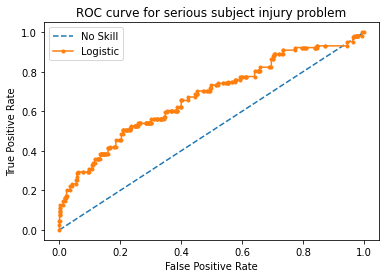

ROC AUC score =  0.6745014893533995


In [25]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val_rs, lr_2.predict_proba(X_val_rs)[:,1]) # lr.predict_proba(X_te)[:,1] means use probabilities for the positive outcome only

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()

# show the plot
plt.show()
print("ROC AUC score = ", roc_auc_score(y_val_rs, lr_2.predict_proba(X_val_rs)[:,1]))

The ROC AUC score is nearly identical to that of the base model.

Since I care more about recall for this project (because false negatives -- predicting that a non-NYPD subject will not be seriously injured during a force incident when in fact they are -- are worse than false positives), I am considering the performance of the second model to be better than the baseline model.

Next, I will do feature selection to hopefully further improve my model's performance.

# Third model

Since I have a lot of features (48) and I want to know which ones are important to keep and which are redundant in an efficient way, I'm going to use L-1 regularization to identify redundant features and remove them from my next model

In [26]:
scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}

lr_3 = LogisticRegression(penalty='l1',class_weight='balanced', solver='liblinear')
lr_3.fit(X_tr_rs, y_tr_rs)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    
cv_results_3 = cross_validate(lr_3, X_tr_rs, y_tr_rs, cv=kf, scoring=scoring_metrics)

# Report results
    
print(f"L1 Regularization Balanced Logistic Regression recall: {(cv_results_3['test_rec'])}")
print("")
print(f"L1 Regularization Balanced Logistic Regression mean recall: {(np.mean(cv_results_3['test_rec'])):.3f}")
print("")
print(f"L1 Regularization Balanced Logistic Regression f2 score: {(cv_results_3['test_f2_score'])}")
print("")
print(f"L1 Regularization Balanced Logistic Regression mean f2 score: {(np.mean(cv_results_3['test_f2_score'])):.3f}")
print("")
print(np.round(lr_3.coef_[0],0))

L1 Regularization Balanced Logistic Regression recall: [0.71666667 0.70491803 0.6302521  0.68243243 0.66086957]

L1 Regularization Balanced Logistic Regression mean recall: 0.679

L1 Regularization Balanced Logistic Regression f2 score: [0.41425819 0.38120567 0.33482143 0.42365772 0.37438424]

L1 Regularization Balanced Logistic Regression mean f2 score: 0.386

[ 4.  1. -4. -0.  0.  0.  3.  0.  2. -1.  2. -0.  0.  4.  2. -1.  1.  0.
  1.  2.  4. -1.  2.  2.  0.  3.  0.  0.  2. -0.  0. -0. -1. -0. -0. -1.
  0. -0. -1. -2. -1. -0. -0.  0.  0.  0.  0. -0.]


The coefficient values equating to 0 are the redundant features and can be removed from the training sample. 

In [28]:
coef = np.round(lr_3.coef_[0],0)
useful_features = pd.Series(X_tr_rs.columns)[list(coef!=0)]
print(f"Number of 'useful' features (i.e., those that don't have coefficients of 0): {(len(useful_features))}")
print(f"Number of original features: {(len(lr_3.coef_[0]))}")

Number of 'useful' features (i.e., those that don't have coefficients of 0): 24
Number of original features: 48


The above shows us that using L1-regularization helped us identify that of the original 48 features in the dataset, half are actually useful (thus far, anyway) because they're not redundant.

Next, update the feature sets for train/val, train, val and test so they only include the smaller subset of 24 features for further modeling.

In [30]:
X_tr_rs = X_tr_rs[useful_features]
X_val_rs =  X_val_rs[useful_features]
X_te = X_te[useful_features]

# Fourth model

Now I'll fit and score a logistic regression model using the smaller feature set.

In [26]:
lr_4 = LogisticRegression(class_weight='balanced', solver='liblinear')
lr_4.fit(X_tr_rs, y_tr_rs)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    
cv_results_4 = cross_validate(lr_4, X_tr_rs, y_tr_rs, cv=kf, scoring=scoring_metrics)

# Report results
    
print(f"recall scores: {(cv_results_4['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_4['test_rec'])):.3f}")
print("")
print(f"F2 score scores: {(cv_results_4['test_f2_score'])}")
print("")
print(f"F2 score score: {(np.mean(cv_results_4['test_f2_score'])):.3f}")

recall scores: [0.7816092  0.75144509 0.72435897 0.74725275 0.73099415]

mean recall score: 0.747

F2 score scores: [0.38095238 0.35971223 0.33254856 0.37383178 0.34780189]

F2 score score: 0.359


Looking at the above recall and F2 scores for the 4th model, we can see that the mean recall score improved from that of the 3rd model and there's somewhat less variance in the individual recall scores. The mean F2 score is a bit lower than that of the 3rd model, but there's also somewhat less variance, so that's a good sign the model is performing better.

Next, I'll calculate the recall and F2 scores of my separate validation set and compare them to those of the training set to further evaluate for over-fitness.

In [34]:
cv_results_4_val = cross_validate(lr_4, X_val_rs, y_val_rs, cv=kf, scoring=scoring_metrics)

print(f"recall scores: {(cv_results_4_val['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_4_val['test_rec'])):.3f}")
print("")
print(f"F2 score scores: {(cv_results_4_val['test_f2_score'])}")
print("")
print(f"F2 score score: {(np.mean(cv_results_4_val['test_f2_score'])):.3f}")

recall scores: [0.75       0.95       0.67307692 0.77419355 0.78688525]

mean recall score: 0.787

F2 score scores: [0.39735099 0.3950104  0.36307054 0.27713626 0.43087971]

F2 score score: 0.373


We can see that there's a LOT of variance in the individual recall and F2 scores using the validation data which means that my model is likely overfitting.

Next, I'll create confusion matrices again to further evaluate the performance of the 4th model. I'll use separate training and validation data to do this.

Confusion matrix with training data

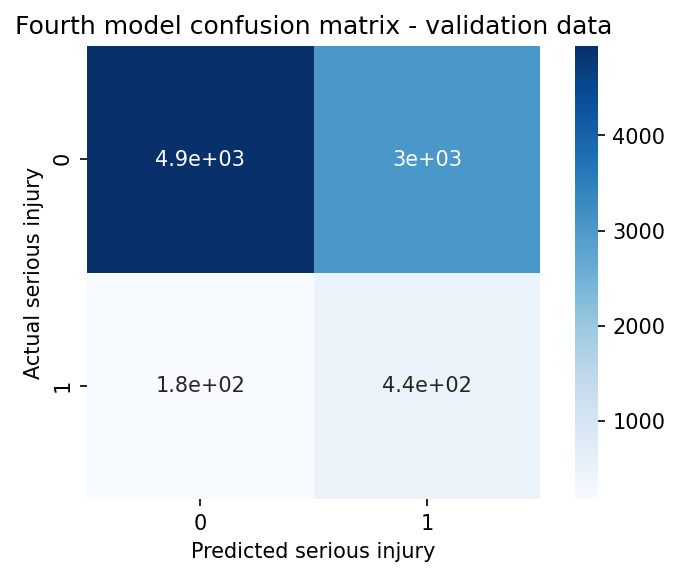

In [35]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_tr_rs, lr_4.predict(X_tr_rs))
plt.figure(dpi=150)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')
plt.title('Fourth model confusion matrix - validation data');

#plt.savefig("confusion_matrix_base_train")

Confusion matrix with validation data

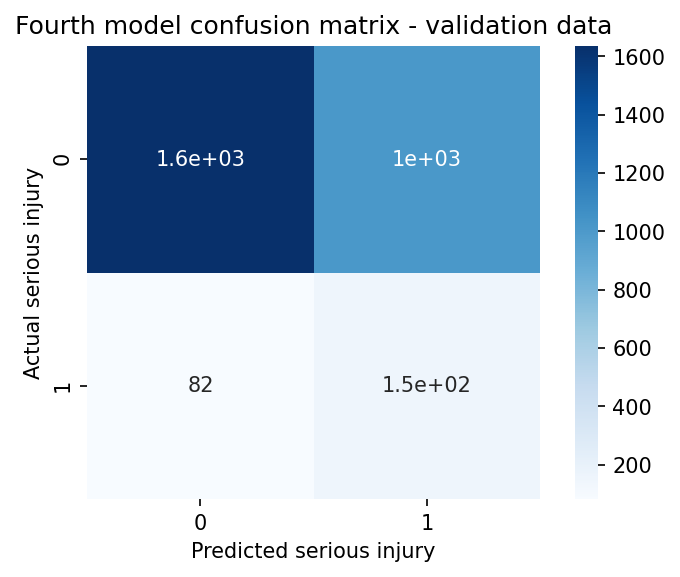

In [36]:
# create and plot confusion matrix 

con_mat = confusion_matrix(y_val_rs, lr_4.predict(X_val_rs))
plt.figure(dpi=150)
sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

plt.xlabel('Predicted serious injury')
plt.ylabel('Actual serious injury')
plt.title('Fourth model confusion matrix - validation data');

#plt.savefig("confusion_matrix_base_train")

By comparing the confusion matrices using first the training data and then the validation data, we can see that recall score for the training dataset is 440/(440+180) = ~ 71%. Meanwhile, with the validation data, the recall score is 150/(150+82) = ~ 65%, so it's lower than the training data but not as much lower as it was with the 3rd model. 

Precision for both is much lower (~15%) compared to recall but about the same compared to in the third model.

Next, I'll plot the ROC curve for the second model. I'll use validation data for this.

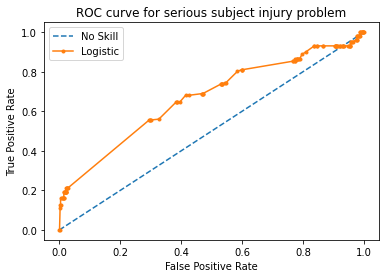

ROC AUC score =  0.6693733009014166


In [37]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_val_rs, lr_4.predict_proba(X_val_rs)[:,1]) # lr.predict_proba(X_te)[:,1] means use probabilities for the positive outcome only

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()

# show the plot
plt.show()
print("ROC AUC score = ", roc_auc_score(y_val_rs, lr_4.predict_proba(X_val_rs)[:,1]))

Next, I'll look at the coefficients of my final model 4 to interpret their meanings

In [77]:
lr_4_feature_coeffs = pd.DataFrame({'features': X_tr_rs.columns,
                   'coefficients': lr_4.coef_.flatten()}).\
                    sort_values('coefficients', ascending = False)

forcetype = 'forcetype'
basis = 'basis_encounter'
force_against = 'force_against_mos'
patrol_borough = 'patrol_borough'
subject_race = 'subject_race'

def feature_group(x):
    if forcetype in x:
        return 1
    elif basis in x:
        return 2
    elif force_against in x:
        return 3
    elif patrol_borough in x:
        return 4
    else:
        return 5

lr_4_feature_coeffs['group'] = lr_4_feature_coeffs['features'].apply(feature_group)
lr_4_feature_coeffs.head()

,features,coefficients,group
0,forcetype_Firearm,3.916510,1
7,basis_encounter_IN CUSTODY INJURY,3.894855,2
13,basis_encounter_SEARCH WARRANT,3.095111,2
17,force_against_mos_Cutting Instrument,2.585567,3
3,basis_encounter_AMBUSH OF MEMBER,2.362289,2


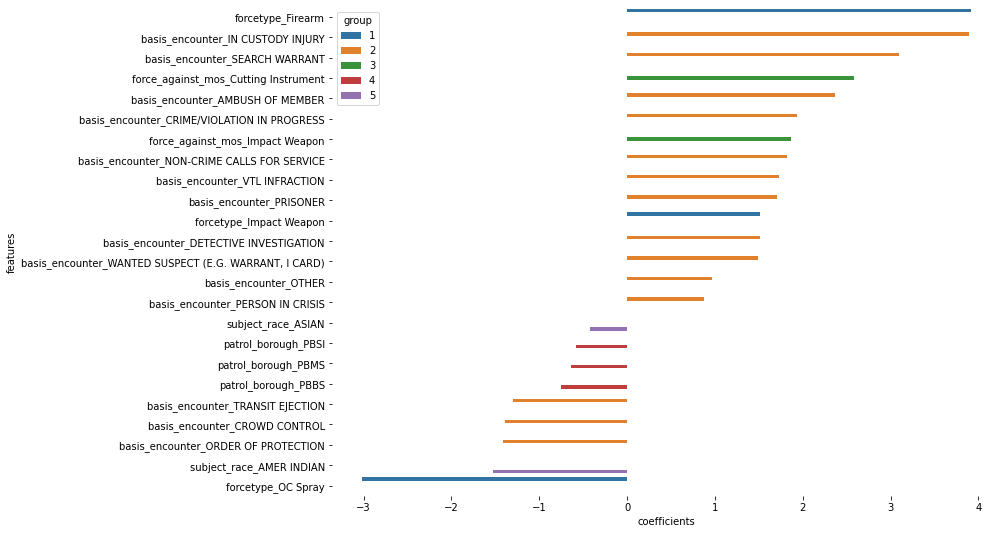

In [71]:
# plot the features and their coefficients
f, ax = plt.subplots(figsize=(12, 9))
sns.set_color_codes("pastel")
sns.barplot(x="coefficients", y="features", data=lr_4_feature_coeffs,hue='group')
sns.despine(left=True, bottom=True)
#plt.savefig('mvp.png',bbox_inches='tight')

The categories for each feature group not included:
- forcetype -> Electrical Weapon (reference category); Physical Force; Police Canine; Restraining Mesh Blanket
- force_against_mos -> No Force (reference category); Firearm; Displayed Weapon; Physical Force
- basis_encounter -> SUSPICIOUS ACTIVITY (reference category); PAST CRIME VIOLATION; HOME VISIT; ANIMAL CONDITION; HOSTAGE BARRICADED
- patrol_borough -> PBBN (reference category), PBBX, PBMN, PBQS, PBQN
- subject_race -> WHITE (reference category), BLACK, HISPANIC, UNK/OTH

To convert the coefficients in log-odds to probabilities, use the following formula:
    
probability = 1 / (1 + exp(-x))

In [82]:
lr_4_feature_coeffs['prob'] = lr_4_feature_coeffs['coefficients'].apply(lambda x: 1 /(1 + np.exp(-x)))
lr_4_feature_coeffs

,features,coefficients,group,prob
0,forcetype_Firearm,3.916510,1,0.980478
7,basis_encounter_IN CUSTODY INJURY,3.894855,2,0.980059
13,basis_encounter_SEARCH WARRANT,3.095111,2,0.956691
17,force_against_mos_Cutting Instrument,2.585567,3,0.929927
3,basis_encounter_AMBUSH OF MEMBER,2.362289,2,0.913906
4,basis_encounter_CRIME/VIOLATION IN PROGRESS,1.935973,2,0.873909
18,force_against_mos_Impact Weapon,1.866967,3,0.866107
8,basis_encounter_NON-CRIME CALLS FOR SERVICE,1.822799,2,0.860902
15,basis_encounter_VTL INFRACTION,1.724812,2,0.848748
12,basis_encounter_PRISONER,1.701981,2,0.845793


We can make predictions from these coefficients. I got help with how to do this using <a href="https://www.displayr.com/how-to-interpret-logistic-regression-coefficients/">this article</a>.

Let's consider the scenario of an Asian non-NYPD subject who... 
- was involved in an encounter with 1+ NYPD members of service on the basis of a person in crisis c) in the patrol borough of Brooklyn South
- used no force against 1+ NYPD members of service
- and experienced force from 1+ NYPD members of service in the form of an impact weapon (impact weapon includes straight baton, expandable baton, or any object (other than a part of the officer’s body) that is used to strike a subject).

If we compute all the effects and add them up we have - 0.419 (subject Asian = yes) + 0.880 (person in crisis basis for encounter = yes) + 0 (no force against mos = 0) - 0.753 (patrol brough Brooklyn South = yes) + 1.513 (impact weapon force experienced = yes) = 1.221

In [86]:
-.419+.88+0+1.513-.753-1.595

-0.3739999999999999

In [87]:
1 /(1 + np.exp(.374))

0.40757483530004773

We then need to add the intercept (which we get by doing lr_4.intercept_), which gives us 1.221 - 1.595 = -0.374. 

Next, we do the logistic transformation to calculate the probability from this log-odds:

probability = 1 / (1 + exp(-x)) = 1 /(1 + exp(- -0.374)) = ~0.41 = ~41%

Thus, given this model, we would expect that an Asian non-NYPD subject who was involved in an encounter with 1+ members of service on the basis of a person in crisis in the patrol borough of Brooklyn South, didn't use any force against a NYPD member of service, and experienced force in the form of an impact weapon would experience a serious (level 2, 3 or 4) injury approximately 40% of the time.

Alternatively, we would expect a Black, Hispanic or White non-NYPD subject in the same boat - and who also didn't use force against an NYPD member of service - to experience a serious injury approximately 60% of the time.

In [88]:
0+.88+1.513-.753-1.595

0.04499999999999971

In [89]:
1 /(1 + np.exp(-0.449))

0.6104014487007485